In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [4]:
import os

project_path = "/content/drive/MyDrive/Face_Mask_Detection"
os.makedirs(project_path, exist_ok=True)
os.chdir(project_path)
print("Working inside:", os.getcwd())


Working inside: /content/drive/MyDrive/Face_Mask_Detection


In [5]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [8]:
# Path where your zip is stored in Google Drive
zip_path = "/content/drive/MyDrive/Face_Mask_Detection/face_mask_detection.zip"

# Extract it inside the same folder
extract_path = "/content/drive/MyDrive/Face_Mask_Detection/dataset/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully!")


✅ Dataset extracted successfully!


In [9]:
import os

for root, dirs, files in os.walk(extract_path):
    print(root, "->", len(files), "files")


/content/drive/MyDrive/Face_Mask_Detection/dataset/ -> 0 files
/content/drive/MyDrive/Face_Mask_Detection/dataset/data -> 0 files
/content/drive/MyDrive/Face_Mask_Detection/dataset/data/with_mask -> 3725 files
/content/drive/MyDrive/Face_Mask_Detection/dataset/data/without_mask -> 3828 files


In [10]:
import shutil
from sklearn.model_selection import train_test_split

# Paths
source_with_mask = os.path.join(extract_path, "data/with_mask")
source_without_mask = os.path.join(extract_path, "data/without_mask")

# Base folder where we’ll put split dataset
base_dir = "/content/drive/MyDrive/Face_Mask_Detection/split_dataset"

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

# Create folders
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(folder, "with_mask"), exist_ok=True)
    os.makedirs(os.path.join(folder, "without_mask"), exist_ok=True)

# Function to split and copy files
def split_and_copy(source, train_dest, val_dest, test_dest, split_size=(0.7,0.2,0.1)):
    files = os.listdir(source)
    train_files, temp_files = train_test_split(files, test_size=(1-split_size[0]), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(split_size[2]/(split_size[1]+split_size[2])), random_state=42)

    for f in train_files:
        shutil.copy(os.path.join(source, f), train_dest)
    for f in val_files:
        shutil.copy(os.path.join(source, f), val_dest)
    for f in test_files:
        shutil.copy(os.path.join(source, f), test_dest)

# Apply to both classes
split_and_copy(source_with_mask,
               os.path.join(train_dir,"with_mask"),
               os.path.join(val_dir,"with_mask"),
               os.path.join(test_dir,"with_mask"))

split_and_copy(source_without_mask,
               os.path.join(train_dir,"without_mask"),
               os.path.join(val_dir,"without_mask"),
               os.path.join(test_dir,"without_mask"))

print("✅ Dataset split into train/val/test!")


✅ Dataset split into train/val/test!


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode="binary"
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode="binary"
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode="binary",
    shuffle=False  # important for evaluation
)


Found 5286 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.
Found 756 images belonging to 2 classes.


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  9/166 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.4777 - loss: 0.7901

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


166/166 ━━━━━━━━━━━━━━━━━━━━ 60s 323ms/step - accuracy: 0.7297 - loss: 0.5148 - val_accuracy: 0.8762 - val_loss: 0.2846
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 49s 298ms/step - accuracy: 0.8814 - loss: 0.2862 - val_accuracy: 0.8981 - val_loss: 0.2263
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 49s 296ms/step - accuracy: 0.8946 - loss: 0.2596 - val_accuracy: 0.9034 - val_loss: 0.2258
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 53s 322ms/step - accuracy: 0.9185 - loss: 0.2147 - val_accuracy: 0.9345 - val_loss: 0.1706
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 78s 298ms/step - accuracy: 0.9298 - loss: 0.1873 - val_accuracy: 0.9332 - val_loss: 0.1709
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 53s 318ms/step - accuracy: 0.9326 - loss: 0.1785 - val_accuracy: 0.9385 - val_loss: 0.1590
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 53s 317ms/step - accuracy: 0.9413 - loss: 0.1611 - val_accuracy: 0.9557 - val_loss: 0.1369
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 49s 293ms/step - accuracy: 0.9465 - loss: 0.1584 - val

- Training accuracy went from 72% → 95%

- Validation accuracy went from 87% → 95.8%

- Validation loss kept decreasing (from 0.28 → 0.12) → shows no overfitting

## Evaluate on Test Set

In [14]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"🎯 Final Test Accuracy: {test_acc*100:.2f}%")


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.9580 - loss: 0.1242
🎯 Final Test Accuracy: 95.24%


In [15]:
model.save("/content/drive/MyDrive/Face_Mask_Detection/mask_detector.h5")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [17]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/MyDrive/Face_Mask_Detection/split_dataset/test/with_mask/with_mask_18.jpg"  # change path to any image
img = image.load_img(img_path, target_size=(128,128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

if prediction[0][0] > 0.5:
    print("😷 Without Mask")
else:
    print("✅ With Mask")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
✅ With Mask


 8/24 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step


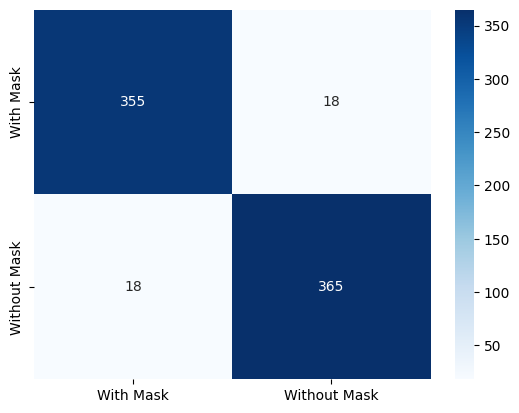

              precision    recall  f1-score   support

   With Mask       0.95      0.95      0.95       373
Without Mask       0.95      0.95      0.95       383

    accuracy                           0.95       756
   macro avg       0.95      0.95      0.95       756
weighted avg       0.95      0.95      0.95       756



In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions on test set
y_pred = model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype("int32")

# True labels
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["With Mask", "Without Mask"], yticklabels=["With Mask", "Without Mask"])
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=["With Mask", "Without Mask"]))


## Pre-trained Model

In [20]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 with pre-trained ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
train_path = '/content/drive/MyDrive/Face_Mask_Detection/split_dataset/train'
val_path   = '/content/drive/MyDrive/Face_Mask_Detection/split_dataset/val'
test_path  = '/content/drive/MyDrive/Face_Mask_Detection/split_dataset/test'


In [21]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)  # 2 classes: Mask / No Mask

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 5286 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


In [29]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 51/166 ━━━━━━━━━━━━━━━━━━━━ 53s 462ms/step - accuracy: 0.7338 - loss: 0.5275

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


166/166 ━━━━━━━━━━━━━━━━━━━━ 129s 671ms/step - accuracy: 0.8586 - loss: 0.3232 - val_accuracy: 0.9828 - val_loss: 0.0641
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 87s 524ms/step - accuracy: 0.9805 - loss: 0.0601 - val_accuracy: 0.9848 - val_loss: 0.0443
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 85s 514ms/step - accuracy: 0.9839 - loss: 0.0448 - val_accuracy: 0.9901 - val_loss: 0.0363
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 86s 516ms/step - accuracy: 0.9872 - loss: 0.0391 - val_accuracy: 0.9887 - val_loss: 0.0355
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 85s 513ms/step - accuracy: 0.9883 - loss: 0.0358 - val_accuracy: 0.9907 - val_loss: 0.0314
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 85s 512ms/step - accuracy: 0.9885 - loss: 0.0298 - val_accuracy: 0.9914 - val_loss: 0.0326
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 84s 503ms/step - accuracy: 0.9906 - loss: 0.0267 - val_accuracy: 0.9841 - val_loss: 0.0399
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 88s 533ms/step - accuracy: 0.9926 - loss: 0.0213 - va

🔹 Training Observations

- Training Accuracy: 99.54%  – your model is learning the training data extremely well.

- Validation Accuracy: 98.74%  – excellent generalization to unseen data.

- Loss Values:

  - Training loss is very low (0.0168)

  - Validation loss is also low (0.0307)

This shows that our model is performing much better than a simple CNN usually does on such tasks.

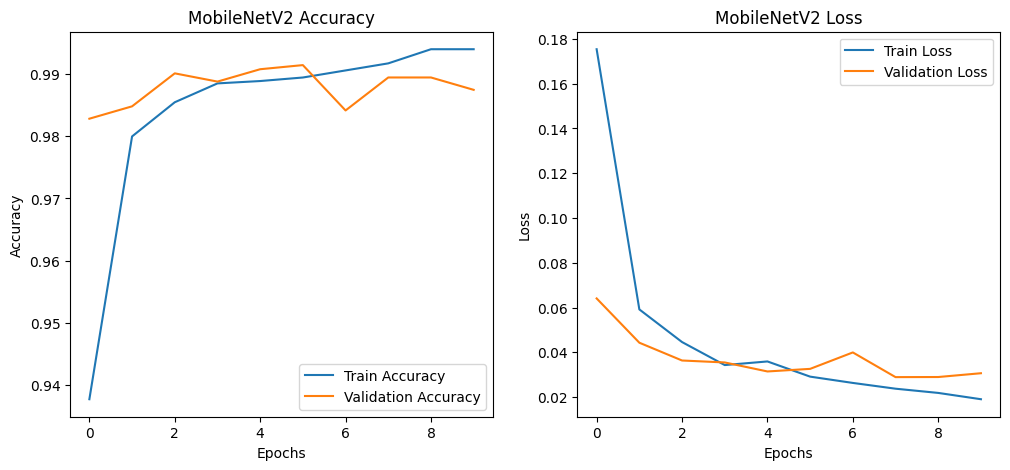

In [30]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [33]:
model.save('/content/drive/MyDrive/Face_Mask_Detection/mobilenetv2_model.h5')


In [34]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img_path = '/content/drive/MyDrive/Face_Mask_Detection/split_dataset/test/without_mask/without_mask_1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # shape (1, 224, 224, 3)
img_array /= 255.0  # rescale as done during training


In [35]:
pred = model.predict(img_array)
class_idx = np.argmax(pred)  # 0 or 1
classes = ['Mask', 'No Mask']

print(f"Prediction: {classes[class_idx]} with confidence {pred[0][class_idx]*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Prediction: No Mask with confidence 98.29%


In [1]:
from tensorflow.keras.models import load_model

# Load old h5 model
old_model = load_model("mobilenetv2_model.h5")

# Save in new Keras format
old_model.save("mobilenetv2_model.keras")
